# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import importlib

import remresAPI.data_loader
data_loader = remresAPI.data_loader
importlib.reload(data_loader)

import remresAPI.preprocessing
preprocessors = remresAPI.preprocessing
importlib.reload(preprocessors)

import remresAPI.pipeline
pipeline = remresAPI.pipeline
importlib.reload(pipeline)

import remresAPI.cue_schema
cue_schema = remresAPI.cue_schema
importlib.reload(cue_schema)

<module 'remresAPI.cue_schema' from 'd:\\Emmanuel_petron_Olateju\\github\\Remres\\notebooks\\remresAPI\\cue_schema.py'>

# Data preprocessing

In [2]:
emg, cue = data_loader.load_all_subjects_data('../dataset/')

## Data cleaning&filtering

In [6]:
data_cleaning_pipeline = pipeline.Pipeline('data_clearning',[
    preprocessors.baselineCorrection('baseline_corrector'),
    preprocessors.filter('1-300Hz_bp_filter',1000,1,300,2)
])

clean_emg = data_cleaning_pipeline.run(emg)

In [8]:
cue = cue_schema.GraspRelease(cue)
print(np.unique(cue))

['grasp' 'release' 'set']


### plot some data Cleaning & filtering results

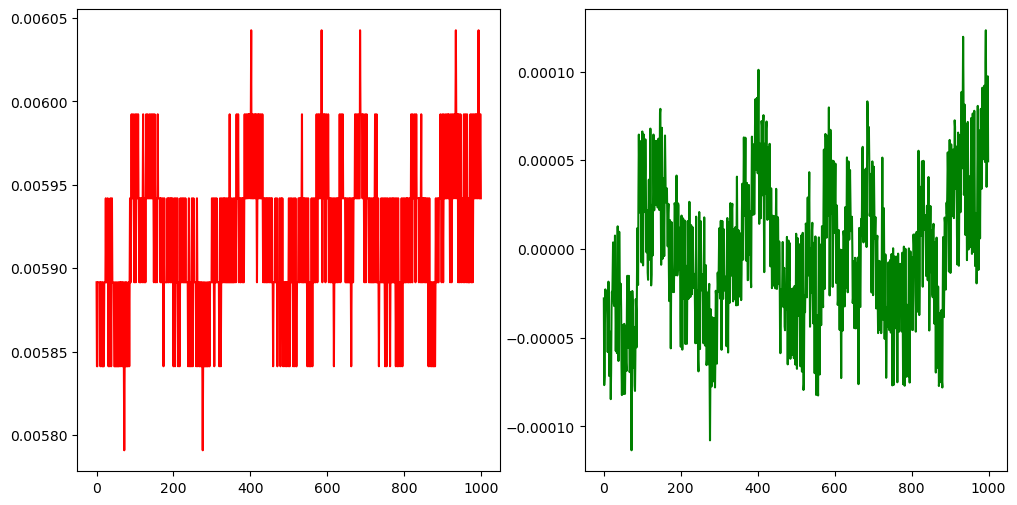

In [10]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(12,6))

y = emg[1,:]
y_clean = clean_emg[1,:]
x = np.arange(0,y.shape[-1],1)

ax[0].plot(x,y,'r')
ax[1].plot(x,y_clean,'g')